# Open Jackson Network Lab

In the lab you will learn

* How to represent arrival rates in a network as a system of linear equations in matrix form
* How to use `scipy.linalg` functions to solve for the arrival rates
* How to analyse the network

## Imports

In [52]:
import piplite
await piplite.install('scipy')
await piplite.install('seaborn')

import scipy.linalg as linalg
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()

ModuleNotFoundError: No module named 'piplite'

## The example queueing network

**Question**: What is the expected number of customers in the entire queuing system?


<img src="image/jn_example.png" width="500">

## Step 1: Solve for $\lambda_i$

Given:

\begin{equation}
        \lambda_j = a_j + \sum_{i=1}^m \lambda_i p_{ij}
    \end{equation}
    
---

Plug the $a_j$ and $p_{ij}$ figures into the equation for $\lambda_j$ 

$$\lambda_1 = 1 + 0.1\lambda_2 + 0.4\lambda_3 $$
$$\lambda_2 = 4 + 0.6\lambda_1 + 0.4\lambda_3 $$
$$\lambda_3 = 3 + 0.3\lambda_1 + 0.3\lambda_2 $$

---
(optional) rearrange the equations with $a_j$ on the RHS

$$\lambda_1 - 0.1\lambda_2 - 0.4\lambda_3 = 1$$
$$-0.6\lambda_1 + \lambda_2 - 0.4\lambda_3 = 4$$
$$-0.3\lambda_1 - 0.3\lambda_2 + \lambda_3 = 3$$

---

Express the system of equations describing arrival rates in matrix form.

$$ \begin{bmatrix} 1 & -0.1 & -0.4\\ -0.6 & 1 & -0.4 \\ -0.3 & -0.3 & 1 \end{bmatrix} \begin{bmatrix} \lambda_1 \\ \lambda_2 \\ \lambda_3 \end{bmatrix}= \begin{bmatrix} 1\\ 4\\ 3 \end{bmatrix}$$

In [53]:
# create the matricies as numpy arrays
a = np.array([[1, -0.1, -0.4], [-0.6, 1, -0.4], [-0.3, -0.3, 1]])
b = np.array([1, 4, 3])

In [54]:
a

array([[ 1. , -0.1, -0.4],
       [-0.6,  1. , -0.4],
       [-0.3, -0.3,  1. ]])

In [55]:
b

array([1, 4, 3])

## Solve for the unknowns

To solve for the unknowns we need to take the dot product of the inverse of a and b

$$\begin{bmatrix} \lambda_1 \\ \lambda_2 \\ \lambda_3 \end{bmatrix} = \begin{bmatrix} 1 & -0.1 & -0.4\\ -0.6 & 1 & -0.4 \\ -0.3 & -0.3 & 1 \end{bmatrix}^{-1} \begin{bmatrix} 1\\ 4\\ 3 \end{bmatrix}$$

In [56]:
np.dot(linalg.inv(a), b)

array([ 5. , 10. ,  7.5])

An alternative way to solve for the unknowns is to use linalg.solve

In [57]:
arrival_rate = linalg.solve(a, b)
arrival_rate

array([ 5. , 10. ,  7.5])

## Step 2: Calculate the traffic intensity

$\rho_i = \dfrac{\lambda_i} {s_i \mu_i}$

Remember that you are treating each queuing system as an independent M/M/s

* Facility 1 is a M/M/1
* Facility 2 is a M/M/2
* Facility 3 is a M/M/1

#### Example solution

In [58]:
servers = np.array([1, 2, 1])
service_rate = np.array([10, 10, 10])

rho = arrival_rate / (servers * service_rate)
rho

array([0.5 , 0.5 , 0.75])

## Step 3: Calculate the number of people in the queue

For an M/M/1

$L_s = \dfrac{\rho}{1 - \rho}$

and for an M/M/s

$p_0 = \left[ \sum_{n=0}^{s-1} \frac{\left(\lambda/ \mu \right)^n}{n!} + \frac{\left( \lambda / \mu \right)^s}{s!\left(1-\rho\right)}  \right]^{-1}$

$L_q = \dfrac{p_o(\lambda/\mu)^s\rho}{s!(1-\rho)^2}$



$L_s = L_q + \dfrac{\lambda}{\mu}$


In [81]:
class MMSQueue:
    '''
    M/M/S/inf/inf/FIFO system
    '''
    def __init__(self, _lambda, mu, s):
        '''
        Constructor
        
        Parameters:
        -------
        _lambda: float
            The arrival rate of customers to the facility
            
        mu: float
            The service rate of the facility
            
        s: int
            The number of servers
        '''
        self._lambda = _lambda
        self.mu = mu
        self.s = int(s)
        self.rho = self._get_traffic_intensity()
        
        #create a dict of performance metrics
        #solve for L_q then use little's law to calculate remaining KPIs
        self.metrics = {}
        self.metrics[r'$\rho$'] = self.rho
        self.metrics[r'$L_q$'] = self._get_mean_queue_length()
        self.metrics[r'$L_s$'] = self.metrics[r'$L_q$'] + (_lambda / mu)
        self.metrics[r'$W_s$'] = self.metrics[r'$L_s$'] / _lambda
        self.metrics[r'$W_q$'] = self.metrics[r'$W_s$'] - (1 / mu)
        
    @property
    def total_in_system(self):
        return self.metrics[r'$L_s$']
        
    def _get_traffic_intensity(self):
        '''
        calculate the traffic intensity (server utilisation)
        of an M/M/s queue
        '''
        return self._lambda / (self.s * self.mu)  
    
    def _get_mean_queue_length(self):
        '''
        Mean length of queue Lq
        '''
        p0 = self.prob_system_empty()
       
        lq = (p0 * ((self._lambda / self.mu)**self.s) * 
              self.rho) / (math.factorial(self.s) * (1 - self.rho)**2)
        return lq
        
    def prob_system_empty(self):
        '''
        The probability that a M/M/s/infinity queue is empty
        '''
        p0 = 0.0

        for n in range(self.s):
            p0 += ((self._lambda / self.mu) ** n) / math.factorial(n)

        p0 += ((self._lambda / self.mu) ** self.s) / (math.factorial(self.s) 
                                                      * (1 - self.rho))
        return p0**-1
    
    def prob_n_in_system(self, n, return_all_solutions=True, as_frame=True):
        '''
        Calculate the probability that n customers
        in the system (queuing + service)

        Parameters:
        --------
        n: int,
            Number of customers in the system

        return_all_solutions: bool, optional (default=True)
            Returns all solutions for 0,1 ... n
            
        as_frame: bool, optional (default=True)
            If True, returns all solutions in a pd.DataFrame
            else returns all solutions as np.ndarray
            has no effect is return_all_solutions == False

        Returns:
        ------
            np.ndarray of solutions

        '''
        p0 = self.prob_system_empty()
        probs = [p0]

        #for n <= s
        for i in range(1, min(self.s+1, n+1)):
            pn = (((self._lambda / self.mu)**i) / math.factorial(i)) * p0
            probs.append(pn)

        #for n > s
        for i in range(self.s+1, n+1):
            pn = (((self._lambda / self.mu)**i) / (math.factorial(self.s) 
                                                   * (self.s**(n-self.s)))) * p0
            probs.append(pn)

        if return_all_solutions:
            results = np.array(probs)
            if as_frame:
                return pd.DataFrame(results, columns=['P(X=n)'])
            else:
                return results
        else:
            return probs[:-1]
        
    def summary_frame(self):
        '''
        Return performance metrics
        
        Returns:
        ---------
        pd.DataFrame
        '''
        df = pd.Series(self.metrics).to_frame()
        df.columns = ['performance']
        return df

In [82]:
queues = [MMSQueue(l, mu, s) for l, mu, s in zip(arrival_rate, service_rate, 
                                                 servers)]

queues[0].summary_frame()

,performance
$\rho$,0.5
$L_q$,0.5
$L_s$,1.0
$W_s$,0.2
$W_q$,0.1


In [83]:
queues[1].summary_frame().round(2)

,performance
$\rho$,0.50
$L_q$,0.33
$L_s$,1.33
$W_s$,0.13
$W_q$,0.03


In [84]:
queues[2].summary_frame()

,performance
$\rho$,0.75
$L_q$,2.25
$L_s$,3.00
$W_s$,0.40
$W_q$,0.30


#### Example solution

In [85]:
# total in system
total_in_system = sum([q.total_in_system for q in queues])
print(f'Expected # of customers in queuing network = {total_in_system:.2f}')

Expected # of customers in queuing network = 5.33


## Convenience class for Network problem

In [86]:
class JacksonNetwork:
    '''
    Open Jackson Queuing Network
    
    A simple implementation where a system of linear equations is specified in
    matrix form by a user as opposed to manually adding nodes.
    
    Create and conveniently holds a collection of MMSQueues.
    '''
    def __init__(self, a, b, service_times, servers):
        '''
        Init the network
        
        Params:
        ------
        a: np.ndarray
            routing of entities through network 
            Note this rearranged for calculation.
            
        b: np.ndarray
            arrival rates to nodes from outside the network
            
        service_times: np.ndarray
            Service rate at each node
            
        servers: np.ndarray
            No. of servers at each node
                
        '''
        self.a = a
        self.b = b
        self.service_times = service_times
        self.servers = servers
        
        # number of queues
        self.n_nodes = len(service_times)
        
        # solve for arrival rates
        self.arrival_rate = linalg.solve(a, b)
        
        # create MMS queues
        self.queues = self._create_mms_queues()
           
    @property
    def total_in_system(self):
        '''
        The expected number of entities in the jackson network
        Sum of expected number of entities in each MMSQueue
        
        Returns:
        -------
        float
        '''
        return sum([q.total_in_system for q in queues])
    
    def summary_frame(self):
        '''
        Tabular summary the performance measures in each queuing node
        
        For each node returns Rho, L_q, L_s, W_q, W_s, 
        
        Returns:
        --------
        pd.DataFrame
        '''
        summary = pd.DataFrame()
        
        for node_id, q in zip(range(len(self.queues)), self.queues):
            node_summary = q.summary_frame()
            node_summary.columns = ['node_' + str(node_id)]
            summary = pd.concat([summary, node_summary], axis=1)
        
        return summary
        
    
    def _create_mms_queues(self):
        '''
        Create and parameterise the required number of MMSQueue objects
        
        Returns:
        --------
        List
        
        '''
        return [MMSQueue(l, mu, s) for l, mu, s in zip(self.arrival_rate, 
                                                       self.service_times, 
                                                       self.servers)]
    

In [87]:
model = JacksonNetwork(a, b, service_rate, servers)
summary = model.summary_frame().round(2)
summary

,node_0,node_1,node_2
$\rho$,0.5,0.50,0.75
$L_q$,0.5,0.33,2.25
$L_s$,1.0,1.33,3.00
$W_s$,0.2,0.13,0.40
$W_q$,0.1,0.03,0.30


In [88]:
print(f'Expected # of customers in queuing network = {model.total_in_system:.2f}')

Expected # of customers in queuing network = 5.33


<Figure size 864x432 with 0 Axes>

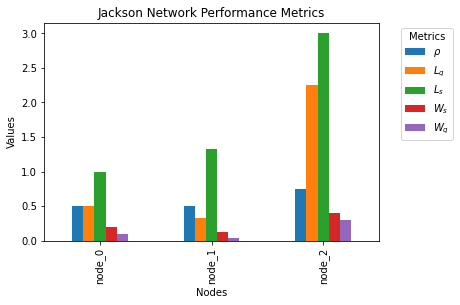

In [89]:
def plot_jackson_network_summary(summary):
    plt.figure(figsize=(12,6))
    summary.T.plot(kind='bar')
    plt.title('Jackson Network Performance Metrics')
    plt.xlabel('Nodes')
    plt.ylabel('Values')
    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
    
plot_jackson_network_summary(summary)

        node_1  node_2  node_3
$\rho$     0.5    0.50    0.75
$L_q$      0.5    0.33    2.25
$L_s$      1.0    1.33    3.00
$W_s$      0.2    0.13    0.40
$W_q$      0.1    0.03    0.30


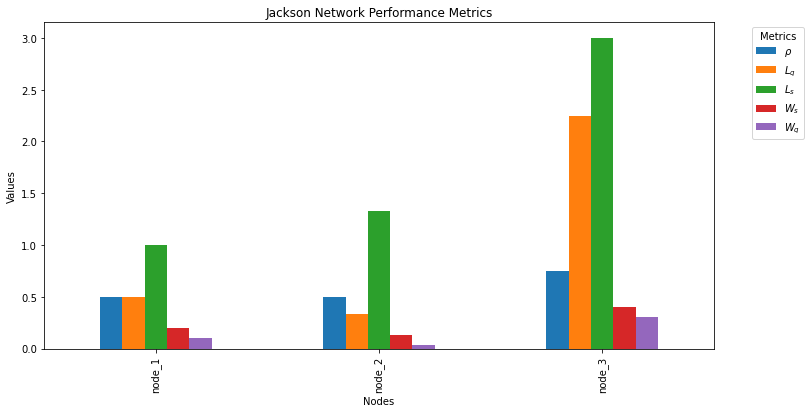

In [92]:

class JacksonNetworkExtData:
    """
    Open Jackson Queuing Network model.
    
    This class models a network of M/M/S queues and computes key performance 
    metrics for each node in the network.
    
    Parameters are read from a csv file
    """
    def __init__(self, arrival_matrix, external_arrival, service_rates, servers):
        """
        Initialize the Jackson Network model.
        
        Parameters:
        -----------
        arrival_matrix : np.ndarray
            Routing matrix of entities through the network.
        external_arrival : np.ndarray
            External arrival rates to each node from outside the network.
        service_rates : np.ndarray
            Service rate at each node.
        servers : np.ndarray
            Number of servers at each node.
        """
        self.arrival_matrix = self.rearrange_matrix(arrival_matrix)
        self.external_arrival = external_arrival
        self.service_rates = service_rates
        self.servers = servers

        # Solve for arrival rates at each node (lambda values)
        self.arrival_rate = linalg.solve(self.arrival_matrix, external_arrival)

        # Create MMS queues for each node
        self.queues = [MMSQueue(l, mu, s) for l, mu, s in zip(self.arrival_rate, service_rates, servers)]

    def rearrange_matrix(self, routing_matrix):
        """
        Rearranges the routing matrix to express the system of equations in the required form.
        
        Converts the routing matrix P into a matrix A where:
        - A_{ii} = 1 (diagonal elements)
        - A_{ij} = -P_{ij} (off-diagonal elements)
        
        Parameters:
        -----------
        routing_matrix : np.ndarray
            Original routing matrix P.
        
        Returns:
        --------
        np.ndarray
            Transformed matrix A.
        """
        n = routing_matrix.shape[0]
        # Initialize the matrix A with identity matrix (diagonal elements = 1)
        A = np.eye(n)
        
        # Fill off-diagonal elements with -P_ij values
        for i in range(n):
            for j in range(n):
                if i != j:
                    A[i, j] = -routing_matrix[i, j]
        
        return A

    def summary_frame(self):
        """
        Generate a summary DataFrame of performance metrics for each node.
        
        Returns:
        --------
        pd.DataFrame
            A DataFrame containing the performance metrics for all nodes.
        """
        summary = pd.DataFrame()
        for i, queue in enumerate(self.queues):
            node_summary = queue.summary_frame()
            node_summary.columns = [f'node_{i + 1}']
            summary = pd.concat([summary, node_summary], axis=1)
        return summary

    def total_in_system(self):
        """
        Calculate the total number of entities in the network.
        
        Returns:
        --------
        float
            Total expected number of customers in the network.
        """
        return sum(queue.metrics[r'$L_s$'] for queue in self.queues)

def read_params_from_csv(file_path):
    """
    Read Jackson Network parameters from a CSV file, ignoring the first column.
    
    Parameters:
    -----------
    file_path : str
        The path to the CSV file.
    
    Returns:
    --------
    np.ndarray
        Arrival matrix (routing matrix).
    np.ndarray
        Service rates for each node.
    np.ndarray
        Number of servers for each node.
    np.ndarray
        External arrival rates.
    """
    df = pd.read_csv(file_path)

    arrival_matrix = df.iloc[:-1, 1:-2].values  
    service_rates = df['service_rate'][:-1].values  
    servers = df['servers'][:-1].values  
    external_arrival = df.iloc[-1, 1:-2].values.astype(float) 

    return arrival_matrix, service_rates, servers, external_arrival

def run_jackson_network(file_path):
    """
    Read parameters from a CSV, create a Jackson Network, and output metrics.
    
    Parameters:
    -----------
    file_path : str
        The path to the CSV file containing the network parameters.
    
    Returns:
    --------
    None
    """
    arrival_matrix, service_rates, servers, external_arrival = read_params_from_csv(file_path)

    # Create Jackson Network model
    model = JacksonNetwork(arrival_matrix, external_arrival, service_rates, servers)

    # Display summary table
    summary = model.summary_frame().round(2)
    print(summary)

    # Plot the performance metrics
    plot_jackson_network_summary(summary)

def plot_jackson_network_summary(summary):
    """
    Plot the Jackson Network performance metrics.
    
    Parameters:
    -----------
    summary : pd.DataFrame
        The summary DataFrame of performance metrics for each node.
    
    Returns:
    --------
    None
    """
    summary.T.plot(kind='bar', figsize=(12, 6))
    plt.title('Jackson Network Performance Metrics')
    plt.xlabel('Nodes')
    plt.ylabel('Values')
    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


# fun function from filepath   
run_jackson_network('../data/parameters.csv')
